<a href="https://colab.research.google.com/github/ChintPatel/CMPE-255-Data-preparation-and-EDA/blob/main/Tabular_Taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.2 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pycaret 3.3.2 requires scikit-learn>1.4.0, but you have scikit-learn 1.2.2 which is incompatible.


                                             |          | [  0%]   00:00 -> (? left)

Report taxi_data_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83691 entries, 0 to 83690
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               51173 non-null  float64
 1   lpep_pickup_datetime   83691 non-null  object 
 2   lpep_dropoff_datetime  83691 non-null  object 
 3   store_and_fwd_flag     51173 non-null  object 
 4   RatecodeID             51173 non-null  float64
 5   PULocationID           83691 non-null  int64  
 6   DOLocationID           83691 non-null  int64  
 7   passenger_count        51173 non-null  float64
 8   trip_distance          83691 non-null  float64
 9   fare_amount            83691 non-null  float64
 10  extra                  83691 non-null  float64
 11  mta_tax                83691 non-null  float64
 12  t

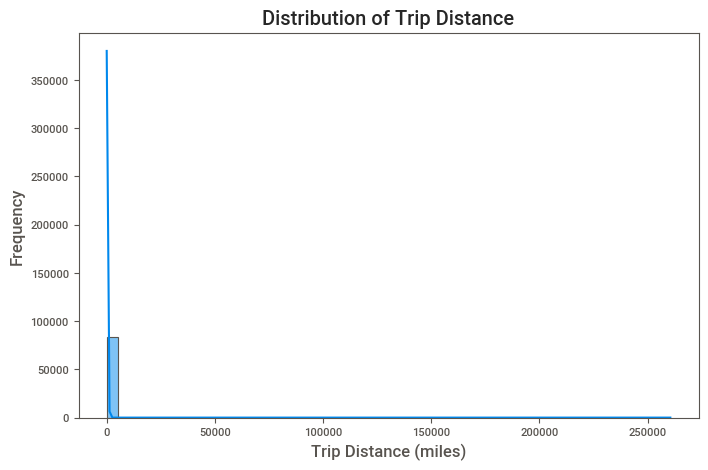

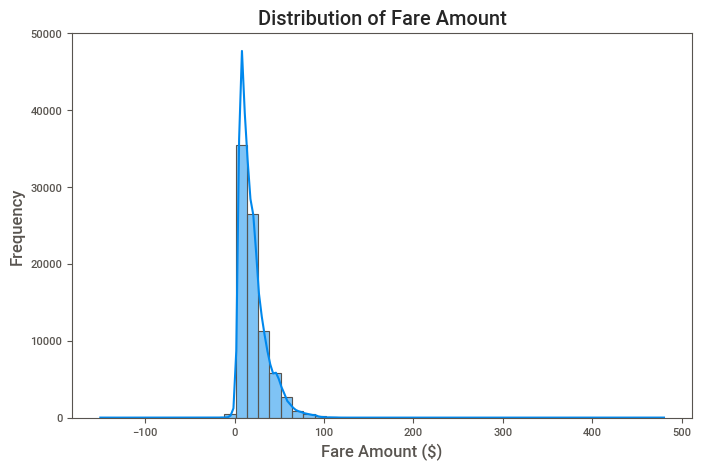

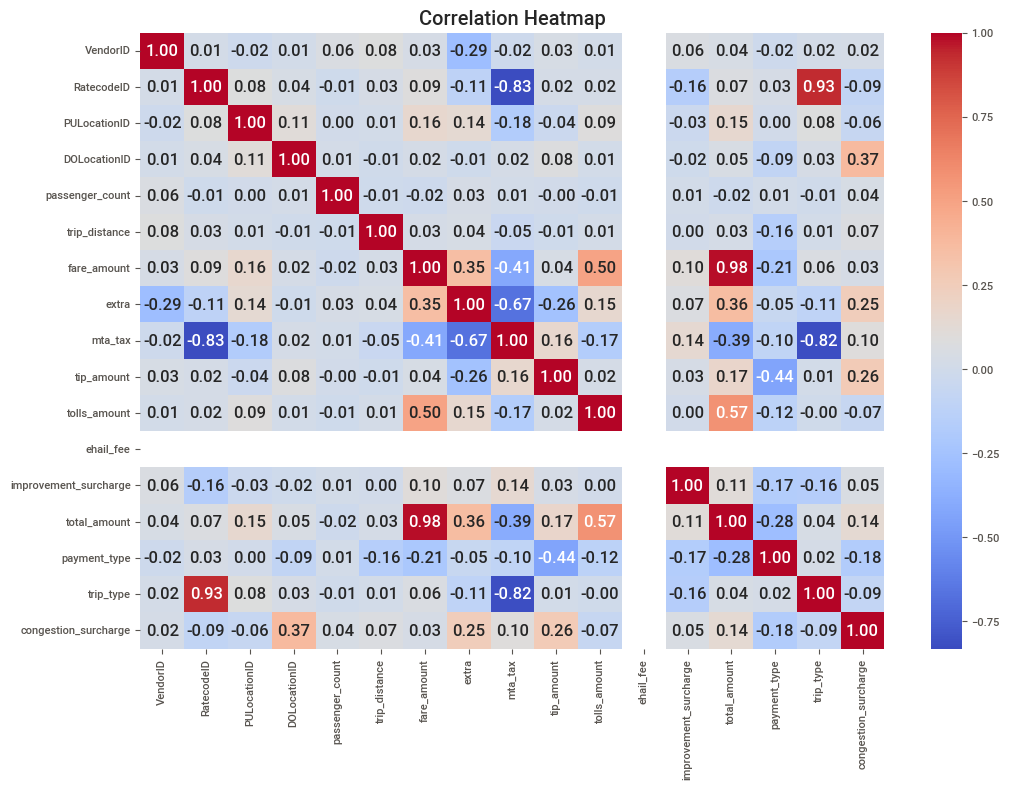


Cleaned dataset saved at: cleaned_taxi_tripdata.csv


In [6]:
# Install required libraries for auto EDA and AutoML
!pip install sweetviz autoviml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

# Load the dataset
file_path = 'taxi_tripdata.csv'
taxi_data = pd.read_csv(file_path)

# Step A1: Detailed EDA with Sweetviz
# Generate an automated EDA report
report = sv.analyze(taxi_data)
report.show_html('taxi_data_eda.html')  # Save and open this HTML file to view detailed insights

# Manual EDA: Summary statistics and missing value overview
print(taxi_data.info())
print("\nSummary Statistics:\n", taxi_data.describe())
print("\nMissing Values:\n", taxi_data.isnull().sum())

# Visualization: Distribution of trip distances
plt.figure(figsize=(8, 5))
sns.histplot(taxi_data['trip_distance'], kde=True, bins=50)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

# Distribution of fare amounts
plt.figure(figsize=(8, 5))
sns.histplot(taxi_data['fare_amount'], kde=True, bins=50)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Visualization: Correlation heatmap for numerical variables
plt.figure(figsize=(12, 8))
sns.heatmap(taxi_data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Step A2: Data Cleaning
# Drop irrelevant columns
columns_to_drop = ['ehail_fee']
taxi_data = taxi_data.drop(columns=columns_to_drop)

# Impute missing values for numerical columns with median
numerical_columns = taxi_data.select_dtypes(include=['float64', 'int64']).columns
taxi_data[numerical_columns] = taxi_data[numerical_columns].fillna(taxi_data[numerical_columns].median())

# Handle missing categorical columns with mode
categorical_columns = taxi_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    taxi_data[col] = taxi_data[col].fillna(taxi_data[col].mode()[0])

# Remove outliers based on z-score for trip_distance and fare_amount
from scipy.stats import zscore

taxi_data = taxi_data[(zscore(taxi_data['trip_distance']) < 3) & (zscore(taxi_data['fare_amount']) < 3)]

# Feature Engineering: Add trip duration
taxi_data['lpep_pickup_datetime'] = pd.to_datetime(taxi_data['lpep_pickup_datetime'])
taxi_data['lpep_dropoff_datetime'] = pd.to_datetime(taxi_data['lpep_dropoff_datetime'])
taxi_data['trip_duration'] = (taxi_data['lpep_dropoff_datetime'] - taxi_data['lpep_pickup_datetime']).dt.total_seconds() / 60

# Remove rows with invalid trip duration
taxi_data = taxi_data[(taxi_data['trip_duration'] > 0) & (taxi_data['trip_duration'] < 240)]

# Save the cleaned dataset for further steps
cleaned_file_path = 'cleaned_taxi_tripdata.csv'
taxi_data.to_csv(cleaned_file_path, index=False)
print("\nCleaned dataset saved at:", cleaned_file_path)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b2c77f18a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


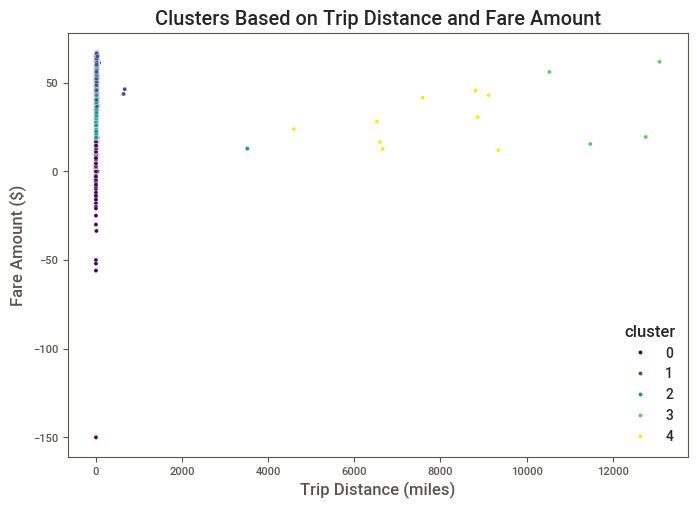

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step B1: Normalize numerical features for clustering
features = ['trip_distance', 'fare_amount', 'trip_duration']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(taxi_data[features])

# Step B2: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
taxi_data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
sns.scatterplot(x=taxi_data['trip_distance'], y=taxi_data['fare_amount'], hue=taxi_data['cluster'], palette='viridis')
plt.title('Clusters Based on Trip Distance and Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()


In [8]:
# Install PyCaret
!pip install pycaret

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoviml 0.1.800 requires scikit-learn<=1.2.2,>=0.24, but you have scikit-learn 1.4.2 which is incompatible.


In [5]:
# Ensure the cleaned dataset is loaded
import pandas as pd

# Load the cleaned dataset
cleaned_file_path = 'cleaned_taxi_tripdata.csv'
taxi_data = pd.read_csv(cleaned_file_path)

# Prepare the dataset for modeling
model_data = taxi_data.copy()

# Dynamically drop columns if they exist
drop_columns = ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'cluster']  # Columns to drop
model_data = model_data.drop(columns=[col for col in drop_columns if col in model_data.columns])

# Verify the data
print("Dataset after dropping unnecessary columns:\n", model_data.head())

# PyCaret regression setup
from pycaret.regression import *

# Initialize the PyCaret setup
regression_setup = setup(
    data=model_data,
    target='fare_amount',
    session_id=42,  # Random seed for reproducibility
    normalize=True,  # Normalize numerical features
    transformation=True,  # Apply power transformation
    remove_outliers=True  # Automatically remove outliers
)

# Compare baseline models
best_model = compare_models()

# Finalize the model
final_model = finalize_model(best_model)

# Evaluate the model
evaluate_model(final_model)

# Save the model
save_model(final_model, 'taxi_fare_model')

# Uncomment to predict on unseen data (if any exists)
# unseen_predictions = predict_model(final_model, data=unseen_data)


Dataset after dropping unnecessary columns:
    VendorID store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  \
0       1.0                  N         1.0            74           168   
1       2.0                  N         1.0           116           265   
2       2.0                  N         1.0            97            33   
3       2.0                  N         1.0            74            42   
4       2.0                  N         1.0            42           244   

   passenger_count  trip_distance  fare_amount  extra  mta_tax  tip_amount  \
0              1.0           1.20          6.0    0.5      0.5        0.00   
1              2.0          13.69         42.0    0.5      0.5        0.00   
2              1.0           0.95          6.5    0.5      0.5        2.34   
3              1.0           1.24          6.5    0.5      0.5        0.00   
4              1.0           1.10          7.0    0.5      0.5        0.00   

   tolls_amount  improvement_surcharge  t

,Description,Value
0,Session id,42
1,Target,fare_amount
2,Target type,Regression
3,Original data shape,"(81822, 18)"
4,Transformed data shape,"(78958, 18)"
5,Transformed train set shape,"(54411, 18)"
6,Transformed test set shape,"(24547, 18)"
7,Numeric features,16
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.2307,0.7925,0.8220,0.9957,0.0752,0.0160,8.5700
gbr,Gradient Boosting Regressor,0.4662,0.9063,0.9097,0.9951,0.0847,0.0346,9.0770
rf,Random Forest Regressor,0.2117,0.9978,0.9540,0.9946,0.0690,0.0140,23.6450
lightgbm,Light Gradient Boosting Machine,0.3023,1.1347,0.9908,0.9939,0.0917,0.0237,5.9070
et,Extra Trees Regressor,0.2319,1.1461,1.0032,0.9938,0.1114,0.0188,14.9460
catboost,CatBoost Regressor,0.2211,1.1700,0.9968,0.9937,0.0990,0.0158,15.8760
dt,Decision Tree Regressor,0.2517,2.0560,1.3728,0.9889,0.0783,0.0153,2.4250
knn,K Neighbors Regressor,1.2531,7.3574,2.7056,0.9601,0.1284,0.1090,3.4710
ada,AdaBoost Regressor,2.2694,8.3350,2.8838,0.9548,0.2275,0.2064,5.8960
omp,Orthogonal Matching Pursuit,2.3903,70.8035,6.1984,0.6201,0.2815,0.2218,2.0180


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['VendorID', 'RatecodeID',
                                              'PULocationID', 'DOLocationID',
                                              'passenger_count', 'trip_distance',
                                              'extra', 'mta_tax', 'tip_amount',
                                              'tolls_amount',
                                              'improvement_surcharge',
                                              'total_amount', 'payment_type',
                                              'trip_type',
                                              'congestion_surcharge',
                                              'trip_duration'],
                                     transformer=Simp...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constra